# Permutation test for time-series data

- first date: 12.August.2021
- updated date: 23.August.2021
- updated date: 25.August.2021

# Background and Motivation

We found a case that Type-2 Error raises when

- a kernel is Matérn kernel
- optimization (of scales) for the given data
- a sample is time at $t$ (a feature is an observation)

Possible reason is that scales learnes over-fitting for the given samples.

The given samples have the following characteristics.

1. in the smaller index of samples, the variance is small.
2. in the bigger index of samples, the variance is big.

We assume that the learned scales (+ Matérn kernel) pays attention strongly on these 2 points.

In this note, we try other approaches to solve the issue.

# Approaches: learning the difference between time-intervals

In the previous experiments, scales lerned weights based on samples.

## Approach 1: only differences

Now, we learn weights not by samples, but differences. In the setting, a sample is __difference of samples__ between $time_t$ and $time_{t+1}$.

Here is formal definitions.

We have samples, where a sample is a time at $t$.

$X = { x_1, x_2, ..., x_T}$, $Y = {y_1, y_2, ..., y_T}$

From $X, Y$, we generate $V = {v_2, v_3, ..., v_T}$ and $W = {w_2, w_3, ..., w_T}$, where $v_t = x_t - x_{t-1}$ and $w_t = y_t - y_{t-1}$

We learn weights on $V$ and $W$.

## Approaches 2: differences and position

We have $V, W$ as the same manner with the approach 1.

With $V, W$ and $X, Y$, we have $A, B$, where $a_2 = (x_2, v_2),  a_3 = (x_3, v_3), ..., a_T = (x_T, v_T)$. $B$ is with $B = {b_2, .., b_T}, where\ b_t\ =\ (y_t, w_t)$

__The motivation__ of the approach 2 is "position(of time-t) and differences".


## Settings

We generate the data with $time_{t+1} = time_t + noise$

We check in both cases

1. the truth is from the same distribution. noise is from $N(0, 0.5)$
2. the truth is from the __different__ distribution. noise of $X$ is from $N(0, 0.5)$, the one of $Y$ is from $Laplase(0, 0.5)$

In the setting 1, permutation test should suggest the same distributions.

In the setting 2, permutation test should suggest the different distributions.

For all settings, we test also "normalization". The normalization is with: $$normalization(x_i, s) = \frac{x_i}{s}$$ 
where $$s = \sqrt{\frac{1}{m}\Sigma_{i=1}^{n}(z_i - \overline{z})^2}$$

$z$ is a concatenation of $X$ and $Y$.


### Kernels

We try 3 types of kernels

1. Matérn kernel with nu parameter with 0.5, 1.5, 2.5
2. RBF kernel whose sigma is initialized with median-heuristic (with optimization)
3. RBF kernel whose sigma is initialized with median-heuristic (without optimization)

For the optimizations, I introduce early-stoppings. 
If an objective-value is within the constant values, a optimizer stops trainings.

In [1]:
import sys
sys.path.append("../../")
sys.path.append(".")

In [2]:
from model_criticism_mmd import ModelTrainerTorchBackend, MMD, TwoSampleDataSet
from model_criticism_mmd import kernels_torch
from model_criticism_mmd import PermutationTest, SelectionKernels
from model_criticism_mmd.models.static import DEFAULT_DEVICE
from model_criticism_mmd.supports.evaluate_stats_tests import StatsTestEvaluator, TestResultGroupsFormatter

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [3]:
import torch
import numpy as np
import tqdm
import typing
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
N_DATA_SIZE = 500
N_TIME_LENGHTH = 100
NOISE_MU_X = 0
NOISE_SIGMA_X = 0.5
NOISE_MU_Y = 0
NOISE_SIGMA_Y = 0.5
THRESHOLD_P_VALUE = 0.05

num_epochs_selection = 500
n_permutation_test = 500

In [5]:
INITIAL_VALUE_AT_ONE = np.random.normal(0, 0.5, (N_DATA_SIZE,))

In [6]:
device_obj = DEFAULT_DEVICE

# Data preparations

In [7]:
def function_data_generation():
    """
    
    Return: a tuple of 5 sub-tuples. The return-tuple is consisted with
        (sample-base-data, time-base-sample, diff-base-sample, time-and-diff-sample, time-and-index-sample).
        Each tuple is consisted with
        (x, y-sample, y-diff)
    """
    x_data_sample = np.zeros((N_DATA_SIZE, N_TIME_LENGHTH))
    y_data_sample = np.zeros((N_DATA_SIZE, N_TIME_LENGHTH))
    y_data_sample_laplace = np.zeros((N_DATA_SIZE, N_TIME_LENGHTH))

    x_data_sample[:, 0] = INITIAL_VALUE_AT_ONE
    y_data_sample[:, 0] = INITIAL_VALUE_AT_ONE
    y_data_sample_laplace[:, 0] = INITIAL_VALUE_AT_ONE

    for time_t in tqdm.tqdm(range(0, N_TIME_LENGHTH - 1)):
        noise_x = np.random.normal(NOISE_MU_X, NOISE_SIGMA_X, (N_DATA_SIZE,))
        noise_y = np.random.normal(NOISE_MU_Y, NOISE_SIGMA_Y, (N_DATA_SIZE,))
        noise_y_laplace = np.random.laplace(NOISE_MU_Y, NOISE_SIGMA_Y, (N_DATA_SIZE,))
        x_data_sample[:, time_t + 1] = x_data_sample[:, time_t].flatten() + noise_x
        y_data_sample[:, time_t + 1] = y_data_sample[:, time_t].flatten() + noise_y
        y_data_sample_laplace[:, time_t + 1] = y_data_sample_laplace[:, time_t].flatten() + noise_y_laplace
        # end if
    assert x_data_sample.shape == (N_DATA_SIZE, N_TIME_LENGHTH)
    assert y_data_sample.shape == (N_DATA_SIZE, N_TIME_LENGHTH)
    assert y_data_sample_laplace.shape == (N_DATA_SIZE, N_TIME_LENGHTH)
    assert np.array_equal(x_data_sample, y_data_sample) is False
    
    x_time = x_data_sample.transpose()
    y_time_normal = y_data_sample.transpose()
    y_time_laplace = y_data_sample_laplace.transpose()

    v_mat_normal = np.zeros((N_TIME_LENGHTH - 1, N_DATA_SIZE))
    w_mat_normal = np.zeros((N_TIME_LENGHTH - 1, N_DATA_SIZE))
    w_mat_laplace = np.zeros((N_TIME_LENGHTH - 1, N_DATA_SIZE))

    a_mat_normal = np.zeros((N_TIME_LENGHTH - 1, N_DATA_SIZE + N_DATA_SIZE))
    b_mat_normal = np.zeros((N_TIME_LENGHTH - 1, N_DATA_SIZE + N_DATA_SIZE))
    b_mat_laplace = np.zeros((N_TIME_LENGHTH - 1, N_DATA_SIZE + N_DATA_SIZE))

    a_ind_mat_normal = np.zeros((N_TIME_LENGHTH - 1, N_DATA_SIZE + 1))
    b_ind_mat_normal = np.zeros((N_TIME_LENGHTH - 1, N_DATA_SIZE + 1))
    b_ind_mat_laplace = np.zeros((N_TIME_LENGHTH - 1, N_DATA_SIZE + 1))

    t_index = 0
    for x, y_normal, y_laplace in zip(x_time, y_time_normal, y_time_laplace):
        if t_index == 0:
            t_index += 1
            continue
        # end if

        # v, w
        v = x - x_time[t_index-1]
        w_normal = y_normal - y_time_normal[t_index-1]
        w_laplace = y_laplace - y_time_laplace[t_index-1]

        v_mat_normal[t_index - 1, :] = v
        w_mat_normal[t_index - 1, :] = w_normal
        w_mat_laplace[t_index - 1, :] = w_laplace

        # a, b
        a_mat_normal[t_index - 1, :] = np.concatenate([v, x])
        b_mat_normal[t_index - 1, :] = np.concatenate([w_normal, y_normal])
        b_mat_laplace[t_index - 1, :] = np.concatenate([w_laplace, y_laplace])

        # a, b of index
        a_ind_mat_normal[t_index - 1, :] = np.concatenate([v, [t_index]])
        b_ind_mat_normal[t_index - 1, :] = np.concatenate([w_normal, [t_index]])
        b_ind_mat_laplace[t_index - 1, :] = np.concatenate([w_laplace, [t_index]])

        t_index += 1
    # end for

    assert np.array_equal(w_mat_normal[-1], np.zeros(99, )) is False
    assert np.array_equal(v_mat_normal[-1], np.zeros(99, )) is False
    assert np.array_equal(w_mat_laplace[-1], np.zeros(99, )) is False
    assert np.array_equal(a_mat_normal[-1], np.zeros(99, )) is False
    assert np.array_equal(b_mat_normal[-1], np.zeros(99, )) is False
    assert np.array_equal(b_mat_laplace[-1], np.zeros(99, )) is False
    
    return (
        (x_data_sample, y_data_sample, y_data_sample_laplace),
        (x_time, y_time_normal, y_time_laplace),
        (v_mat_normal, w_mat_normal, w_mat_laplace),
        (a_mat_normal, b_mat_normal, b_mat_laplace),
        (a_ind_mat_normal, b_ind_mat_normal, b_ind_mat_laplace)
    )

In [8]:
origin_train, time_train, diff_train, time_diff_train, time_index_train = function_data_generation()
origin_eval, time_eval, diff_eval, time_diff_eval, time_index_eval = function_data_generation()

100%|██████████| 99/99 [00:00<00:00, 3254.05it/s]


In [9]:
import pandas

In [10]:
print(f"X(observation * time-length){origin_train[0].shape} Y(observation * time-length){origin_train[1].shape}")

X(observation * time-length)(500, 100) Y(observation * time-length)(500, 100)


<AxesSubplot:title={'center':'x in time-series sequence'}>

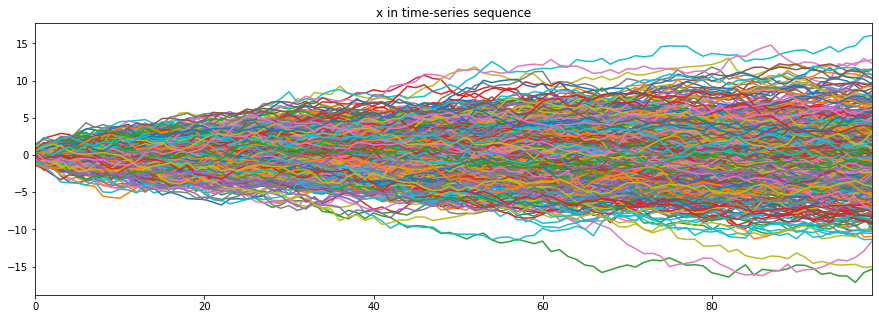

In [11]:
pandas.DataFrame(origin_train[0]).transpose().plot(kind='line', legend=False, figsize=(15, 5), title='x in time-series sequence')

<AxesSubplot:title={'center':'y in time-series sequence'}>

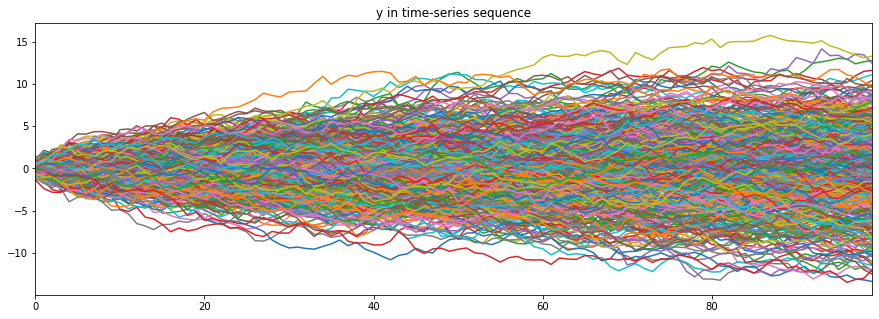

In [12]:
pandas.DataFrame(origin_train[1]).transpose().plot(kind='line', legend=False, figsize=(15, 5), title='y in time-series sequence')

<AxesSubplot:title={'center':'y-laplase in time-series sequence'}>

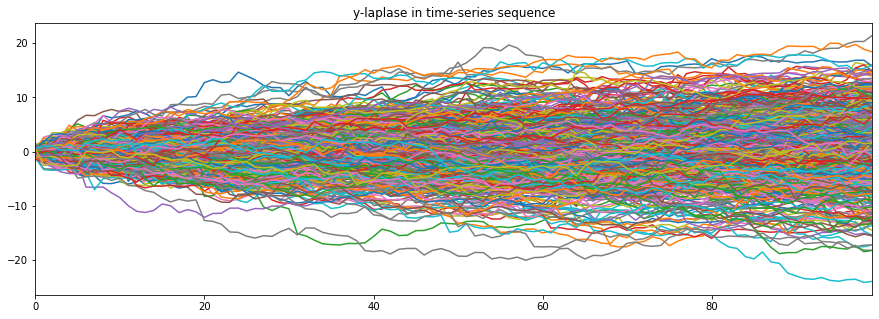

In [13]:
pandas.DataFrame(origin_train[2]).transpose().plot(kind='line', legend=False, figsize=(15, 5), title='y-laplase in time-series sequence')

generations of $V, W, A, B$

### observation of $V, W$

<AxesSubplot:title={'center':'series of V'}>

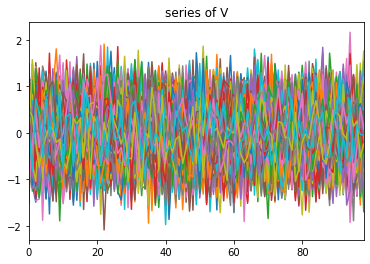

In [14]:
pandas.DataFrame(diff_train[0]).plot(kind='line', title='series of V', legend=False)

<AxesSubplot:title={'center':'series of W(normal)'}>

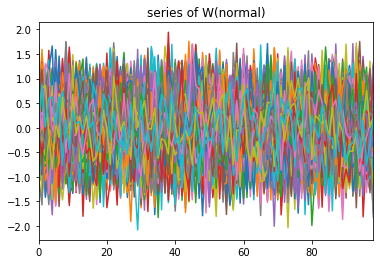

In [15]:
pandas.DataFrame(diff_train[1]).plot(kind='line', title='series of W(normal)', legend=False)

<AxesSubplot:title={'center':'series of W(laplase)'}>

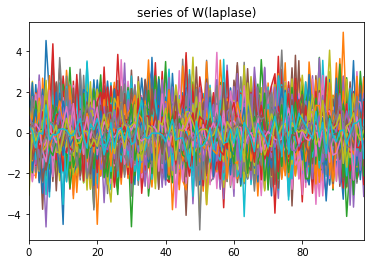

In [16]:
pandas.DataFrame(diff_train[2]).plot(kind='line', title='series of W(laplase)', legend=False)

### kernels

In [17]:
import math
from pprint import pprint

In [18]:
rbf_kernel = kernels_torch.BasicRBFKernelFunction(device_obj=device_obj, log_sigma=-1.0)
matern_0_5 = kernels_torch.MaternKernelFunction(nu=0.5, device_obj=device_obj, lengthscale=-1.0)
matern_1_5 = kernels_torch.MaternKernelFunction(nu=1.5, device_obj=device_obj, lengthscale=-1.0)
matern_2_5 = kernels_torch.MaternKernelFunction(nu=2.5, device_obj=device_obj, lengthscale=-1.0)

kernels_optimization = [(None, rbf_kernel), (None, matern_0_5), (None, matern_1_5), (None, matern_2_5)]
kernels_non_optimization = [rbf_kernel, matern_2_5]

In [19]:
import typing

In [20]:
test_eval = StatsTestEvaluator(candidate_kernels=kernels_optimization, 
                               kernels_no_optimization=kernels_non_optimization, 
                               device_obj=device_obj, 
                               num_epochs=num_epochs_selection, 
                               n_permutation_test=n_permutation_test)

# Experiment of Approach-1

a case of same distribution

In [21]:
def function_normalization_approach1(x: np.ndarray, y: np.ndarray) -> typing.Tuple[np.ndarray, np.ndarray, float]:
    """
    Args:
        x: samples of x.
        y: samples of y,
    Return:
        Tuple (normalized-x, normalized-y, standard deviation of concat(x, y))
    """
    z = np.concatenate([x, y])
    std = np.std(z)
    x_norm = x / std
    y_norm = y / std
    print(f'normalization result. std = {std}. x = [{x_norm.min()}, {x_norm.max()}], y = [{y_norm.min()}, {y_norm.max()}]')
    return x_norm, y_norm, std

without normalization 

In [37]:
evals_app1_without_norm = test_eval.interface(code_approach='approach1-without-normalization', 
                                              x_train=diff_train[0],
                                              y_train_same=diff_train[1],
                                              y_train_diff=diff_train[2],
                                              x_eval=diff_eval[0],
                                              y_eval_same=diff_eval[1],
                                              y_eval_diff=diff_eval[2])

2021-08-25 21:45:36,186 - model_criticism_mmd.logger_unit - INFO - Set the initial scales value
../../model_criticism_mmd/backends/backend_torch.py:286: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scales = torch.tensor(init_scale.clone().detach().cpu(), requires_grad=True, device=self.device_obj)
2021-08-25 21:45:36,188 - model_criticism_mmd.logger_unit - INFO - Getting median initial sigma value...
2021-08-25 21:45:36,215 - model_criticism_mmd.logger_unit - INFO - initial by median-heuristics 2.59 with is_log=True
2021-08-25 21:45:36,238 - model_criticism_mmd.logger_unit - INFO - Validation at 0. MMD^2 = 0.04845737865526678, ratio = [484.57378655] obj = [-6.18326971]
2021-08-25 21:45:36,585 - model_criticism_mmd.logger_unit - INFO -      5: [avg train] MMD^2 0.012874383749937546 obj [-4.85782467] val-MMD^2 0.04848574506688086 val-rat

with normalization

In [23]:
normalize_v_mat, normalize_w_mat, std = function_normalization_approach1(diff_train[0], diff_train[1])
normalize_v_mat_eval, normalize_w_mat_eval, std = function_normalization_approach1(diff_eval[0], diff_eval[1])

evals_app1_with_norm_1 = test_eval.interface(code_approach='approach1-with-normalization', 
                                             x_train=normalize_v_mat, 
                                             x_eval=normalize_v_mat_eval, 
                                             y_train_same=normalize_w_mat, 
                                             y_eval_same=normalize_w_mat_eval)

2021-08-25 21:15:18,756 - model_criticism_mmd.logger_unit - INFO - Set the initial scales value
../../model_criticism_mmd/backends/backend_torch.py:286: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scales = torch.tensor(init_scale.clone().detach().cpu(), requires_grad=True, device=self.device_obj)
2021-08-25 21:15:18,758 - model_criticism_mmd.logger_unit - INFO - Getting median initial sigma value...
2021-08-25 21:15:18,780 - model_criticism_mmd.logger_unit - INFO - initial by median-heuristics 3.28 with is_log=True
2021-08-25 21:15:18,786 - model_criticism_mmd.logger_unit - INFO - Validation at 0. MMD^2 = 0.048457378655267114, ratio = [484.57378655] obj = [-6.18326971]


normalization result. std = 0.5018242531051347. x = [-4.152050300124935, 4.310761895395905], y = [-4.1457120447984535, 3.871080769130138]
normalization result. std = 0.5014408209102076. x = [-4.19385712656875, 4.841989724162209], y = [-4.299505164360793, 4.812468028649045]


2021-08-25 21:15:19,114 - model_criticism_mmd.logger_unit - INFO -      5: [avg train] MMD^2 0.012874383749937546 obj [-4.85782467] val-MMD^2 0.04848574506688097 val-ratio [484.85745067] val-obj [-6.18385493]  elapsed: 0.0
2021-08-25 21:15:20,268 - model_criticism_mmd.logger_unit - INFO -     25: [avg train] MMD^2 0.012708289941125495 obj [-4.84483962] val-MMD^2 0.048889686139705235 val-ratio [488.8968614] val-obj [-6.19215155]  elapsed: 0.0
2021-08-25 21:15:21,622 - model_criticism_mmd.logger_unit - INFO -     50: [avg train] MMD^2 0.012687651077179285 obj [-4.84321426] val-MMD^2 0.049464860307476655 val-ratio [494.64860307] val-obj [-6.20384762]  elapsed: 0.0
2021-08-25 21:15:24,197 - model_criticism_mmd.logger_unit - INFO -    100: [avg train] MMD^2 0.013341590402886738 obj [-4.89347135] val-MMD^2 0.050305097871653603 val-ratio [503.05097872] val-obj [-6.22069151]  elapsed: 0.0
2021-08-25 21:15:29,399 - model_criticism_mmd.logger_unit - INFO -    200: [avg train] MMD^2 0.01469494910

In [36]:
normalize_v_mat_diff, normalize_w_mat_diff, std_same = function_normalization_approach1(diff_train[0], diff_train[2])
normalize_v_mat_diff_eval, normalize_w_mat_diff_eval, std_same = function_normalization_approach1(diff_eval[0], diff_eval[2])

evals_app1_with_norm_2 = test_eval.interface(code_approach='approach1-with-normalization', 
                                           x_train=normalize_v_mat_diff, 
                                           x_eval=normalize_v_mat_diff_eval, 
                                           y_train_diff=normalize_w_mat_diff, 
                                           y_eval_diff=normalize_w_mat_diff_eval)

2021-08-25 21:40:53,152 - model_criticism_mmd.logger_unit - INFO - Set the initial scales value
../../model_criticism_mmd/backends/backend_torch.py:286: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scales = torch.tensor(init_scale.clone().detach().cpu(), requires_grad=True, device=self.device_obj)
2021-08-25 21:40:53,154 - model_criticism_mmd.logger_unit - INFO - Getting median initial sigma value...
2021-08-25 21:40:53,181 - model_criticism_mmd.logger_unit - INFO - initial by median-heuristics 3.27 with is_log=True
2021-08-25 21:40:53,186 - model_criticism_mmd.logger_unit - INFO - Validation at 0. MMD^2 = 0.08004371881002459, ratio = [48.95007457] obj = [-3.89080089]


normalization result. std = 0.6108595549042325. x = [-3.4109305878694194, 3.5413129762867794], y = [-7.793612401421336, 8.031729090579056]
normalization result. std = 0.6174035434791957. x = [-3.4061533700893327, 3.93255161517307], y = [-8.571927032223904, 8.6859372394819]


2021-08-25 21:40:53,492 - model_criticism_mmd.logger_unit - INFO -      5: [avg train] MMD^2 0.03946440991138478 obj [-3.52776211] val-MMD^2 0.08001322679621414 val-ratio [48.94975023] val-obj [-3.89079427]  elapsed: 0.0
2021-08-25 21:40:54,446 - model_criticism_mmd.logger_unit - INFO -     25: [avg train] MMD^2 0.039190203811175106 obj [-3.61881505] val-MMD^2 0.07970740516246433 val-ratio [48.8759961] val-obj [-3.8892864]  elapsed: 0.0
2021-08-25 21:40:55,663 - model_criticism_mmd.logger_unit - INFO -     50: [avg train] MMD^2 0.03867609053681942 obj [-3.79834543] val-MMD^2 0.07908372329891311 val-ratio [48.46051753] val-obj [-3.88074939]  elapsed: 0.0
2021-08-25 21:40:57,996 - model_criticism_mmd.logger_unit - INFO -    100: [avg train] MMD^2 0.035399212140958314 obj [-5.86927466] val-MMD^2 0.07452390937830611 val-ratio [43.82562518] val-obj [-3.7802187]  elapsed: 0.0
2021-08-25 21:41:02,742 - model_criticism_mmd.logger_unit - INFO -    200: [avg train] MMD^2 0.039490648078238544 obj

## Experimet of approach 2

In [25]:
evals_app2_without_norm = test_eval.interface(code_approach='approach2-without-normalization', 
                                              x_train=time_diff_train[0], 
                                              x_eval=time_diff_eval[0], 
                                              y_train_same=time_diff_train[1], 
                                              y_eval_same=time_diff_eval[1],
                                              y_train_diff=time_diff_train[2],
                                              y_eval_diff=time_diff_eval[2])

2021-08-25 21:20:35,277 - model_criticism_mmd.logger_unit - INFO - Set the initial scales value
../../model_criticism_mmd/backends/backend_torch.py:286: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scales = torch.tensor(init_scale.clone().detach().cpu(), requires_grad=True, device=self.device_obj)
2021-08-25 21:20:35,279 - model_criticism_mmd.logger_unit - INFO - Getting median initial sigma value...
2021-08-25 21:20:35,314 - model_criticism_mmd.logger_unit - INFO - initial by median-heuristics 4.19 with is_log=True
2021-08-25 21:20:35,321 - model_criticism_mmd.logger_unit - INFO - Validation at 0. MMD^2 = 1.5956341097853826, ratio = [143.90047791] obj = [-4.96912194]
2021-08-25 21:20:35,660 - model_criticism_mmd.logger_unit - INFO -      5: [avg train] MMD^2 0.6683048835072726 obj [-2.82441541] val-MMD^2 1.5956802581200622 val-ratio [

with normalization

In [26]:
def function_normalization_approach2(x: np.ndarray, y: np.ndarray, 
                                     v: np.ndarray, w: np.ndarray
                                    ) -> typing.Tuple[np.ndarray, np.ndarray]:
    """
    Args:
        x: samples of x.
        y: samples of y,
    Return:
        Tuple (normalized-x+v, normalized-y+w)
    """
    z = np.concatenate([x, y])
    std = np.std(z)
    x_norm = x / std
    y_norm = y / std
    print(f'normalization result. std = {std}. x = [{x_norm.min()}, {x_norm.max()}], y = [{y_norm.min()}, {y_norm.max()}]')
    
    z_2 = np.concatenate([v, w])
    std_2 = np.std(z_2)
    v_norm = v / std_2
    w_norm = w / std_2
    print(f'normalization result. std = {std_2}. v = [{v_norm.min()}, {v_norm.max()}], w = [{w_norm.min()}, {w_norm.max()}]')
    
    # +1 data(with zero) for v_norm and w_norm. Because v_norm and w_norm have -1 sample by x_norm and y_norm.
    v_norm_zero_head = np.concatenate([np.zeros((1, v_norm.shape[-1])), v_norm])
    w_norm_zero_head = np.concatenate([np.zeros((1, w_norm.shape[-1])), w_norm])
    
    concat_x = np.concatenate([x_norm, v_norm_zero_head], axis=1)
    concat_y = np.concatenate([y_norm, w_norm_zero_head], axis=1)
    
    return concat_x, concat_y

In [27]:
a_train, b_train = function_normalization_approach2(x=time_train[0], y=time_train[1], v=diff_train[0], w=diff_train[1])
a_eval, b_eval = function_normalization_approach2(x=time_eval[0], y=time_eval[1], v=diff_eval[0], w=diff_eval[1])
evals_app2_without_norm_1 = test_eval.interface(code_approach='approach2-with-normalization', 
                                              x_train=a_train,
                                              x_eval=a_eval,
                                              y_train_same=b_train, 
                                              y_eval_same=b_eval)

2021-08-25 21:26:47,891 - model_criticism_mmd.logger_unit - INFO - Set the initial scales value
../../model_criticism_mmd/backends/backend_torch.py:286: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scales = torch.tensor(init_scale.clone().detach().cpu(), requires_grad=True, device=self.device_obj)
2021-08-25 21:26:47,894 - model_criticism_mmd.logger_unit - INFO - Getting median initial sigma value...
2021-08-25 21:26:47,930 - model_criticism_mmd.logger_unit - INFO - initial by median-heuristics 3.47 with is_log=True
2021-08-25 21:26:47,945 - model_criticism_mmd.logger_unit - INFO - Validation at 0. MMD^2 = 0.679214059081474, ratio = [111.26757687] obj = [-4.7119379]


normalization result. std = 3.5669069307380425. x = [-4.805088877822556, 4.511356949318113], y = [-3.777373376955397, 4.413287550298807]
normalization result. std = 0.5018242531051347. v = [-4.152050300124935, 4.310761895395905], w = [-4.1457120447984535, 3.871080769130138]
normalization result. std = 3.4405778054008413. x = [-3.9279973993935293, 4.888234774013551], y = [-4.330378326025316, 4.864177428588118]
normalization result. std = 0.5014408209102076. v = [-4.19385712656875, 4.841989724162209], w = [-4.299505164360793, 4.812468028649045]


2021-08-25 21:26:48,304 - model_criticism_mmd.logger_unit - INFO -      5: [avg train] MMD^2 0.23338965676351253 obj [-2.71934614] val-MMD^2 0.6791059229924186 val-ratio [111.19884818] val-obj [-4.71132002]  elapsed: 0.0
2021-08-25 21:26:49,551 - model_criticism_mmd.logger_unit - INFO -     25: [avg train] MMD^2 0.23351993132896387 obj [-2.72387999] val-MMD^2 0.6780952378735441 val-ratio [110.55652244] val-obj [-4.70552691]  elapsed: 0.0
2021-08-25 21:26:50,987 - model_criticism_mmd.logger_unit - INFO -     50: [avg train] MMD^2 0.23372308394715668 obj [-2.73111004] val-MMD^2 0.6765347276850471 val-ratio [109.57132994] val-obj [-4.69657575]  elapsed: 0.0
2021-08-25 21:26:53,856 - model_criticism_mmd.logger_unit - INFO -    100: [avg train] MMD^2 0.23410029925769127 obj [-2.74596736] val-MMD^2 0.6733278408412512 val-ratio [107.59141979] val-obj [-4.6783409]  elapsed: 0.0
2021-08-25 21:26:59,590 - model_criticism_mmd.logger_unit - INFO -    200: [avg train] MMD^2 0.2346697731030517 obj [

In [28]:
a_train, b_train = function_normalization_approach2(x=time_train[0], y=time_train[2], v=diff_train[0], w=diff_train[2])
a_eval, b_eval = function_normalization_approach2(x=time_eval[0], y=time_eval[2], v=diff_eval[0], w=diff_eval[2])
evals_app2_without_norm_2 = test_eval.interface(code_approach='approach2-with-normalization', 
                                              x_train=a_train, 
                                              x_eval=a_eval, 
                                              y_train_diff=b_train, 
                                              y_eval_diff=b_eval)

2021-08-25 21:30:02,926 - model_criticism_mmd.logger_unit - INFO - Set the initial scales value
../../model_criticism_mmd/backends/backend_torch.py:286: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scales = torch.tensor(init_scale.clone().detach().cpu(), requires_grad=True, device=self.device_obj)
2021-08-25 21:30:02,928 - model_criticism_mmd.logger_unit - INFO - Getting median initial sigma value...
2021-08-25 21:30:02,951 - model_criticism_mmd.logger_unit - INFO - initial by median-heuristics 3.5 with is_log=True
2021-08-25 21:30:02,961 - model_criticism_mmd.logger_unit - INFO - Validation at 0. MMD^2 = 0.7249553234886218, ratio = [103.71883791] obj = [-4.64168376]


normalization result. std = 4.29935598024775. x = [-3.986481905629481, 3.7427908839101836], y = [-5.602912335530396, 4.982275485478859]
normalization result. std = 0.6108595549042325. v = [-3.4109305878694194, 3.5413129762867794], w = [-7.793612401421336, 8.031729090579056]
normalization result. std = 4.200304783919527. x = [-3.217523814882412, 4.004078974327555], y = [-5.94200424511334, 4.9649517493327435]
normalization result. std = 0.6174035434791957. v = [-3.4061533700893327, 3.93255161517307], w = [-8.571927032223904, 8.6859372394819]


2021-08-25 21:30:03,327 - model_criticism_mmd.logger_unit - INFO -      5: [avg train] MMD^2 0.2603718073770469 obj [-2.71032346] val-MMD^2 0.7247765288926746 val-ratio [103.6993499] val-obj [-4.64149585]  elapsed: 0.0
2021-08-25 21:30:04,572 - model_criticism_mmd.logger_unit - INFO -     25: [avg train] MMD^2 0.26011327371531456 obj [-2.71550883] val-MMD^2 0.7230999919061504 val-ratio [103.51318765] val-obj [-4.63969902]  elapsed: 0.0
2021-08-25 21:30:06,016 - model_criticism_mmd.logger_unit - INFO -     50: [avg train] MMD^2 0.2596972545939671 obj [-2.72383056] val-MMD^2 0.7204944371912355 val-ratio [103.20955191] val-obj [-4.63676141]  elapsed: 0.0
2021-08-25 21:30:08,956 - model_criticism_mmd.logger_unit - INFO -    100: [avg train] MMD^2 0.2588033801097953 obj [-2.74116934] val-MMD^2 0.7150851890839255 val-ratio [102.51884086] val-obj [-4.63004659]  elapsed: 0.0
2021-08-25 21:30:14,828 - model_criticism_mmd.logger_unit - INFO -    200: [avg train] MMD^2 0.256837757316263 obj [-2.7

# Experiment-3: Original data plus index

In [29]:
x_time_sample = time_train[0]
y_time_sample = time_train[1]
y_time_sample_laplace = time_train[2]

train_x_time_sample_index = np.concatenate([
    x_time_sample,
    np.arange(0, len(x_time_sample)).reshape((len(x_time_sample), 1))
], axis=1)

train_y_time_sample_index = np.concatenate([
    y_time_sample,
    np.arange(0, len(y_time_sample)).reshape((len(y_time_sample), 1))
], axis=1)

train_y_time_sample_laplace_index = np.concatenate([
    y_time_sample_laplace,
    np.arange(0, len(y_time_sample_laplace)).reshape((len(y_time_sample_laplace), 1))
], axis=1)

In [30]:
x_time_sample = time_eval[0]
y_time_sample = time_eval[1]
y_time_sample_laplace = time_eval[2]

eval_x_time_sample_index = np.concatenate([
    x_time_sample,
    np.arange(0, len(x_time_sample)).reshape((len(x_time_sample), 1))
], axis=1)

eval_y_time_sample_index = np.concatenate([
    y_time_sample,
    np.arange(0, len(y_time_sample)).reshape((len(y_time_sample), 1))
], axis=1)

eval_y_time_sample_laplace_index = np.concatenate([
    y_time_sample_laplace,
    np.arange(0, len(y_time_sample_laplace)).reshape((len(y_time_sample_laplace), 1))
], axis=1)

In [31]:
evals_app3 = test_eval.interface(code_approach='approach3', 
                                                  x_train=train_x_time_sample_index, 
                                                  x_eval=eval_x_time_sample_index, 
                                                  y_train_same=train_y_time_sample_index,
                                                  y_eval_same=eval_y_time_sample_index,
                                                  y_train_diff=train_y_time_sample_laplace_index, 
                                                  y_eval_diff=eval_y_time_sample_laplace_index)

2021-08-25 21:33:08,562 - model_criticism_mmd.logger_unit - INFO - Set the initial scales value
../../model_criticism_mmd/backends/backend_torch.py:286: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scales = torch.tensor(init_scale.clone().detach().cpu(), requires_grad=True, device=self.device_obj)
2021-08-25 21:33:08,565 - model_criticism_mmd.logger_unit - INFO - Getting median initial sigma value...
2021-08-25 21:33:08,589 - model_criticism_mmd.logger_unit - INFO - initial by median-heuristics 4.27 with is_log=True
2021-08-25 21:33:08,595 - model_criticism_mmd.logger_unit - INFO - Validation at 0. MMD^2 = 1.5794951658685554, ratio = [138.54897538] obj = [-4.93122388]
2021-08-25 21:33:08,935 - model_criticism_mmd.logger_unit - INFO -      5: [avg train] MMD^2 0.6037619155283076 obj [-2.74326164] val-MMD^2 1.579640750636329 val-ratio [1

# Result

In [38]:
test_formatter = TestResultGroupsFormatter(evals_app1_without_norm + evals_app1_with_norm_1 + evals_app1_with_norm_2 + evals_app2_without_norm + evals_app2_without_norm_1 + evals_app2_without_norm_2 + evals_app3)

In [39]:
df_results = test_formatter.format_result_table()
df_results_summary = test_formatter.format_result_summary_table()

In [40]:
df_results_summary

,test-key,X=Y,X!=Y
0,approach1-with-normalization-BasicRBFKernelFun...,pass,pass
1,approach1-with-normalization-BasicRBFKernelFun...,pass,pass
2,approach1-with-normalization-MaternKernelFunct...,pass,pass
3,approach1-with-normalization-MaternKernelFunct...,pass,pass
4,approach1-with-normalization-MaternKernelFunct...,pass,pass
5,approach1-with-normalization-MaternKernelFunct...,pass,pass
6,approach1-without-normalization-BasicRBFKernel...,pass,pass
7,approach1-without-normalization-BasicRBFKernel...,pass,pass
8,approach1-without-normalization-MaternKernelFu...,pass,pass
9,approach1-without-normalization-MaternKernelFu...,pass,pass


In [41]:
with pandas.ExcelWriter('output.xlsx') as writer:
    df_results_summary.to_excel(writer, sheet_name='summary')
    df_results.to_excel(writer, sheet_name='all')